In [1]:
def wcss(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_pix2world(x, y ,0)
    return [recx, recy]

In [2]:
def wcss3(hdu, x, y):
    from astropy import wcs
    from astropy.io import fits
    CARD = [('NAXIS1',hdu['NAXIS1']),('NAXIS2',hdu['NAXIS2']),('BUNIT',hdu['BUNIT']),('CTYPE1',hdu['CTYPE1']),
             ('CTYPE2',hdu['CTYPE2']),('CRVAL1',hdu['CRVAL1']),('CRVAL2',hdu['CRVAL2']),('CRPIX1',hdu['CRPIX1']),
             ('CRPIX2',hdu['CRPIX2']),('CROTA2',hdu['CROTA2']),('CDELT1',hdu['CDELT1']),('CDELT2',hdu['CDELT2'])]
    hdr = fits.Header(cards= CARD)
    w = wcs.WCS(hdr)
    recx, recy = w.wcs_world2pix(x, y ,0)
    return [recx, recy]

In [3]:
def Plot_Cent_Spec(gal_name,O2):

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.io import fits

    data_mode = ['SL2','SL1','LL2','LL1']
#    gal_name = ['mrk{0}'.format(str(33))]
#gal_list = open('subsam_Sy2.txt','r')
#gal_name = gal_list.readlines()

    for name in gal_name:
        f, ax = plt.subplots(1, 1, figsize=[15,6])
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
        for mode in data_mode:
            file_n = 'ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.split('_')[0],mode,O2)
            file_u = 'ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.split('_')[0],mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube[0].header
            crpix = wcss3(flux_header, crval[0], crval[1])
#            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]
#    nn = np.argmax(flux_sum)
#    xx = (nn)//mm[1]
#    yy = (nn)%mm[1]
#    print(flux_sum[xx,yy],np.max(flux_sum))
#    print(xx,yy)
            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            flux_header = cube['PRIMARY'].header
#    print(n)
            flux_max = flux[xx[0]][yy[0]]
            flux_max_u = flux_u[xx[0]][yy[0]]
            ax.errorbar(wave, flux_max, flux_max_u, c='k', ecolor='r',elinewidth=5)
#plt.xlim(32)
#    plt.ylim(-1)
        ax.set_title(name.split('_')[0],fontsize=18)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('$\lambda\ (um)$', fontsize=12)
        ax.set_ylabel('$Flux\ $'+flux_header['BUNIT'], fontsize=12)
        dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
        if(os.path.exists(dirs) != True):
            os.makedirs(dirs)
        f.savefig(dirs+'/{0}_Cent_Spec.png'.format(name.split('_')[0]))
    return

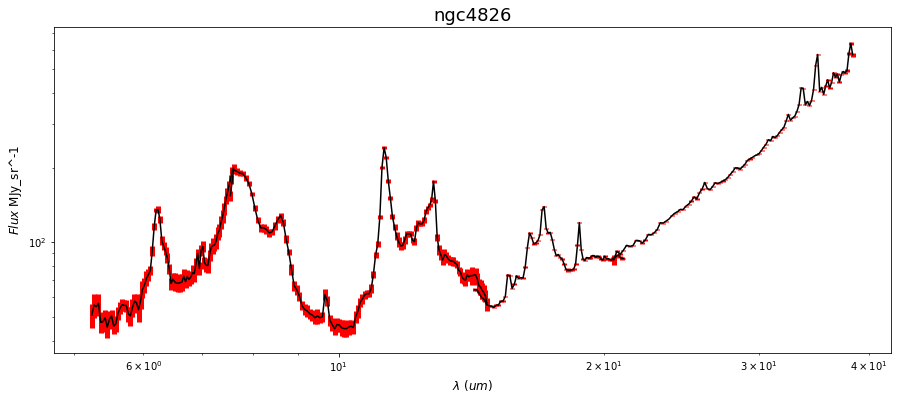

In [28]:
#Plot_Cent_Spec(['ngc4826_Sy2'],'LL2')

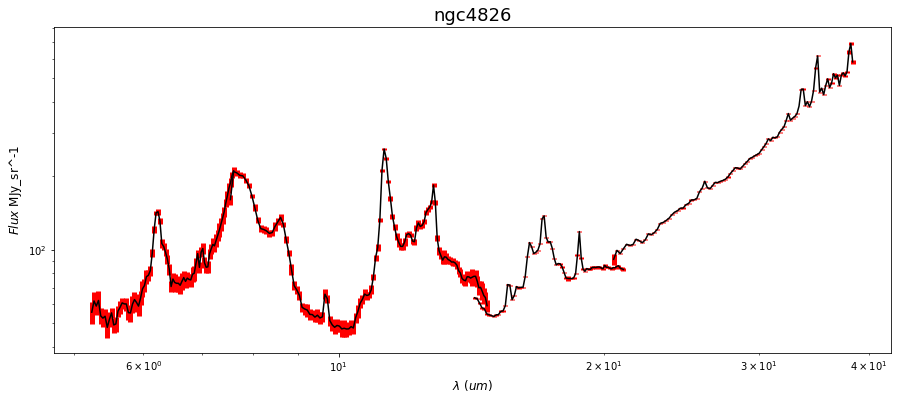

In [29]:
#Plot_Cent_Spec(['ngc4826_Sy2'],'LL1')

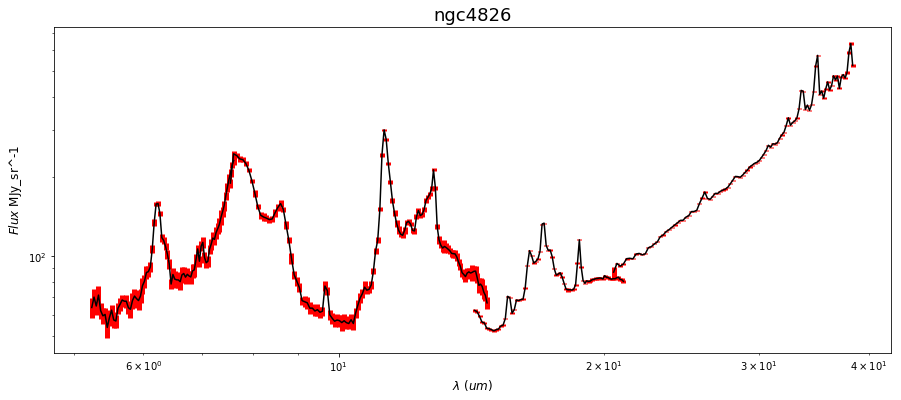

In [30]:
#Plot_Cent_Spec(['ngc4826_Sy2'],'SL2')

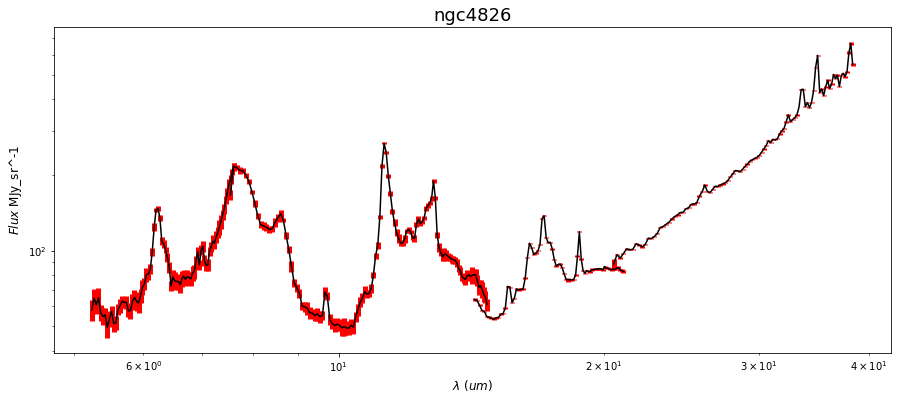

In [31]:
#Plot_Cent_Spec(['ngc4826_Sy2'],'SL1')

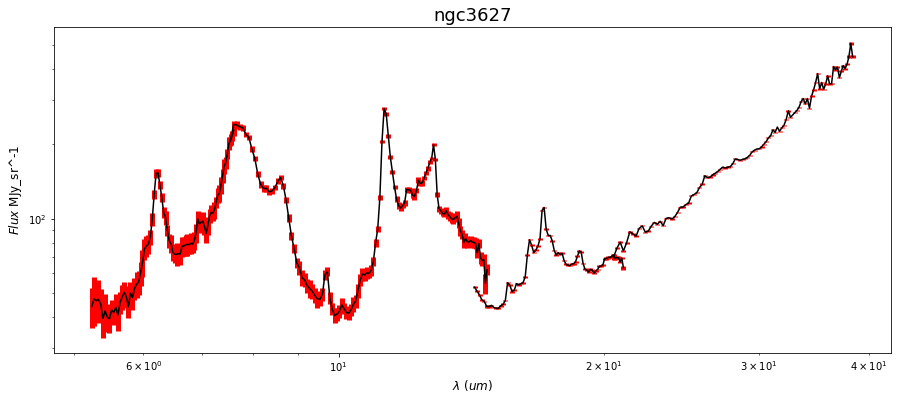

In [32]:
#Plot_Cent_Spec(['ngc3627_Sy2'],'LL2')

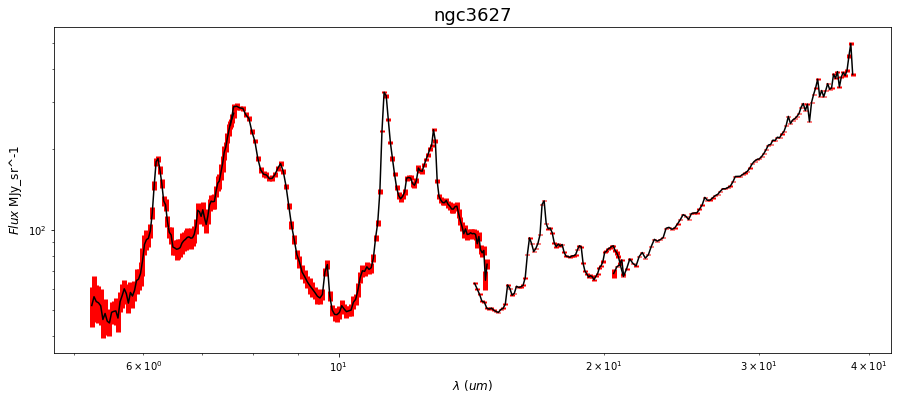

In [33]:
#Plot_Cent_Spec(['ngc3627_Sy2'],'LL1')

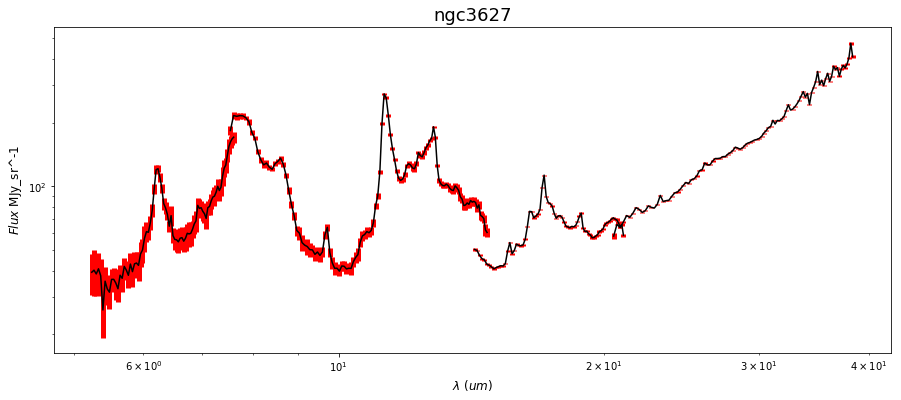

In [34]:
#Plot_Cent_Spec(['ngc3627_Sy2'],'SL2')

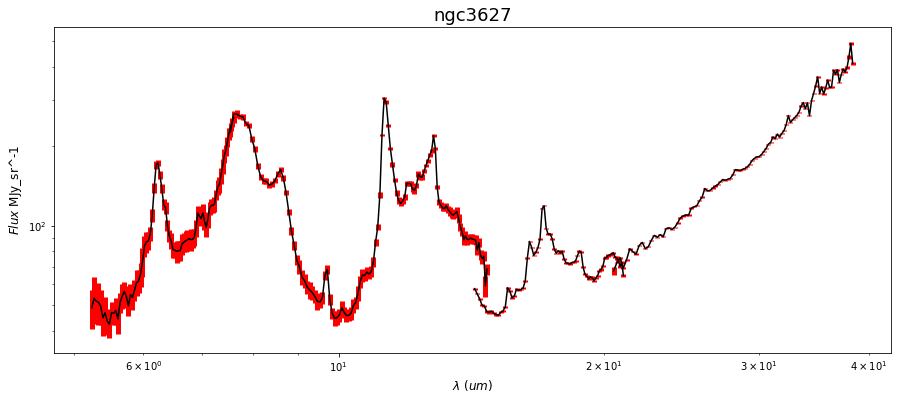

In [35]:
#Plot_Cent_Spec(['ngc3627_Sy2'],'SL1')

In [3]:
def Plot_ratio(gal_name, sn, n_pix, O2):

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.io import fits


    data_mode = ['SL2','SL1','LL2','LL1']
#gal_file = open('nuc_region_gal.txt','r')
#gal_name = gal_file.readlines()
#gal_name = ['ngc{0}'.format(str(3031))]

    for name in gal_name:
        f, ax = plt.subplots(1, 2, figsize=[15,6], sharey = True)
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]

        for num in range(0,len(data_mode)):
            file_n = nnmm +'{0}_on2_{1}.fits'.format(data_mode[num],O2)
            file_u = nnmm +'{0}_on2_{1}_unc.fits'.format(data_mode[num],O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube['PRIMARY'].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            if(data_mode[num][0:2] == 'LL'):
                an = np.min([yy[0], mm[1]-yy[0]-1, n_pix-2])
                flux_axis = flux[:,yy[0]]
                flux_axis_u = flux_u[:,yy[0]]
                mask_part = ~np.isnan(flux_axis.sum(axis=1))
                part_pix = mask_part.sum()     
                flux_axis = flux_axis[mask_part].sum(axis=0)
                flux_axis = flux_axis/part_pix

                flux_axis_u = (flux_axis_u[mask_part]**2).sum(axis=0)
                flux_axis_u = np.sqrt(flux_axis_u)/part_pix

            else:
                an = np.min([xx[0], mm[0]-xx[0]-1, n_pix-2])
                flux_axis = flux[xx[0],:]
                flux_axis_u = flux_u[xx[0],:]
                mask_part = ~np.isnan(flux_axis.sum(axis=1))
                part_pix = mask_part.sum()
                flux_axis = flux_axis[mask_part].sum(axis=0)
                flux_axis = flux_axis/part_pix

                flux_axis_u = (flux_axis_u[mask_part]**2).sum(axis=0)
                flux_axis_u = np.sqrt(flux_axis_u)/part_pix

            colors = plt.cm.hot(np.linspace(0,1,n_pix))

            for j in range(1,an+1,1):
                if(data_mode[num][0:2] == 'SL'):
                    flux_part = flux[xx[0]-j:xx[0]+j+1,:]
                    flux_part_u = flux_u[xx[0]-j:xx[0]+j+1,:]
                    flux_cen = flux[xx[0]-j+1:xx[0]+j,:]
                    flux_cen_u = flux_u[xx[0]-j+1:xx[0]+j,:]
                else:
                    flux_part = flux[:,yy[0]-j:yy[0]+j+1]
                    flux_part_u = flux_u[:,yy[0]-j:yy[0]+j+1]
                    flux_cen = flux[:,yy[0]-j+1:yy[0]+j]
                    flux_cen_u = flux_u[:,yy[0]-j+1:yy[0]+j]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = flux_cen[mask_cen].sum(axis=(0))
                flux_out = (flux_part - flux_cen)/(part_pix - cen_pix)

                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                flux_out_u = np.sqrt(flux_part_u - flux_cen_u)/(part_pix - cen_pix)
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
                    par = (j)*np.abs(flux_header['CDELT1'])*3600
#              ax1.plot(wave, flux_out, c=colors[j], ls='-.', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    if(data_mode[num][2] == '1'):
                        ax[num//2].plot(wave, flux_out/flux_axis, c=colors[j], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                        ax[num//2].legend(loc=3, fontsize='x-small')
                    else:
                        ax[num//2].plot(wave, flux_out/flux_axis, c=colors[j], ls='-')

            ax[0].set_xscale('log')
            ax[0].set_yscale('log')
            ax[1].set_xscale('log')
            ax[1].set_yscale('log')
            ax[0].set_ylim([10**-1,3*10**0])
            ax[1].set_ylim([10**-1,3*10**0])
            ax[0].set_xlabel('$\lambda\ (um)$', fontsize=18)
            ax[1].set_xlabel('$\lambda\ (um)$', fontsize=18)
            ax[0].set_ylabel('$Ratio\_F$', fontsize=18)
            ax[0].set_title('{0}({1})'.format(name.split('_')[0],'SL'), fontsize=20)
            ax[1].set_title('{0}({1})'.format(name.split('_')[0],'LL'), fontsize=20)
            dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
            f.savefig(dirs+'/{0}_Spec_RL.png'.format(name.split('_')[0]))
            
        f, ax = plt.subplots(1, 2, figsize=[15,6], sharey = True)
        aabb = nnmm + '{0}_on2_{0}.fits'.format(O2)
        if(os.path.isfile(aabb)):
            cube = fits.open(aabb)
        else:
            print('No such file:{0}'.format(aabb))
            continue
        flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
        flux_sum = flux.sum(axis=2)
        flux_sum[np.isnan(flux_sum)] = 0
        flux_header = cube[0].header
        crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
        crval = wcss(flux_header, crpixx, crpixy)

        for num in range(0,len(data_mode)):
            file_n = nnmm +'{0}_on2_{1}.fits'.format(data_mode[num],O2)
            file_u = nnmm +'{0}_on2_{1}_unc.fits'.format(data_mode[num],O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube['PRIMARY'].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(crpix[0])]
            yy = [int(crpix[1])]

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            if(data_mode[num][0:2] == 'SL'):
                an = np.min([yy[0], mm[1]-yy[0]-1, n_pix-2])
                flux_axis = flux[:,yy[0]]
                flux_axis_u = flux_u[:,yy[0]]
                mask_part = ~np.isnan(flux_axis.sum(axis=1))
                part_pix = mask_part.sum()
                flux_axis = flux_axis[mask_part].sum(axis=0)
                flux_axis = flux_axis/part_pix

                flux_axis_u = (flux_axis_u[mask_part]**2).sum(axis=0)
                flux_axis_u = np.sqrt(flux_axis_u)/part_pix

            else:
                an = np.min([xx[0], mm[0]-xx[0]-1, n_pix-2])
                flux_axis = flux[xx[0],:]
                flux_axis_u = flux_u[xx[0],:]
                mask_part = ~np.isnan(flux_axis.sum(axis=1))
                part_pix = mask_part.sum()
                flux_axis = flux_axis[mask_part].sum(axis=0)
                flux_axis = flux_axis/part_pix

                flux_axis_u = (flux_axis_u[mask_part]**2).sum(axis=0)
                flux_axis_u = np.sqrt(flux_axis_u)/part_pix
            colors = plt.cm.hot(np.linspace(0,1,n_pix))

            for j in range(1,an+1,1):
                if(data_mode[num][0:2] == 'LL'):
                    flux_part = flux[xx[0]-j:xx[0]+j+1,:]
                    flux_part_u = flux_u[xx[0]-j:xx[0]+j+1,:]
                    flux_cen = flux[xx[0]-j+1:xx[0]+j,:]
                    flux_cen_u = flux_u[xx[0]-j+1:xx[0]+j,:]
                else:
                    flux_part = flux[:,yy[0]-j:yy[0]+j+1]
                    flux_part_u = flux_u[:,yy[0]-j:yy[0]+j+1]
                    flux_cen = flux[:,yy[0]-j+1:yy[0]+j]
                    flux_cen_u = flux_u[:,yy[0]-j+1:yy[0]+j]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = flux_cen[mask_cen].sum(axis=(0))
                flux_out = (flux_part - flux_cen)/(part_pix - cen_pix)

                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                flux_out_u = np.sqrt(flux_part_u - flux_cen_u)/(part_pix - cen_pix)
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
                    par = (j)*np.abs(flux_header['CDELT1'])*3600
#              ax1.plot(wave, flux_out, c=colors[j], ls='-.', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    if(data_mode[num][2] == '1'):
                        ax[num//2].plot(wave, flux_out/flux_axis, c=colors[j], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                        ax[num//2].legend(loc=3, fontsize='x-small')
                    else:
                        ax[num//2].plot(wave, flux_out/flux_axis, c=colors[j], ls='-')

            ax[0].set_xscale('log')
            ax[0].set_yscale('log')
            ax[1].set_xscale('log')
            ax[1].set_yscale('log')
            ax[0].set_ylim([10**-1,3*10**0])
            ax[1].set_ylim([10**-1,3*10**0])
            ax[0].set_xlabel('$\lambda\ (um)$', fontsize=18)
            ax[1].set_xlabel('$\lambda\ (um)$', fontsize=18)
            ax[0].set_ylabel('$Ratio\_F$', fontsize=18)
            ax[0].set_title('{0}({1})'.format(name.split('_')[0],'SL'), fontsize=20)
            ax[1].set_title('{0}({1})'.format(name.split('_')[0],'LL'), fontsize=20)
            dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
            f.savefig(dirs+'/{0}_Spec_RS.png'.format(name.split('_')[0]))
    return

In [27]:
def Plot_ratiooo(gal_name, sn, n_pix, O2):

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.io import fits


    data_mode = ['SL2','SL1','LL2','LL1']
#gal_file = open('nuc_region_gal.txt','r')
#gal_name = gal_file.readlines()
#gal_name = ['ngc{0}'.format(str(3031))]

    for name in gal_name:
        f, ax = plt.subplots(1, 1, figsize=[15,6], sharey = True)
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
        for mode in data_mode:
            file_n = 'ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.split('_')[0],mode,O2)
            file_u = 'ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.split('_')[0],mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube[0].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]
#    nn = np.argmax(flux_sum)

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            flux_header = cube['PRIMARY'].header
#    print(n)
            flux_max = flux[xx[0]][yy[0]]
            flux_max_u = flux_u[xx[0]][yy[0]]

            bn = np.min([xx[0],yy[0],mm[0]-xx[0]-1,mm[1]-yy[0]-1])
            colors = plt.cm.hot(np.linspace(0,1,n_pix))
            for i in range(1,bn+1,1):
                flux_part = flux[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                flux_cen = flux[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = flux_cen[mask_cen].sum(axis=(0))
                flux_out = (flux_part - flux_cen)/(part_pix - cen_pix)

                flux_part_u = flux_u[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
#                    print((flux_part_u[mask_part]).shape)
                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = flux_u[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                flux_out_u = np.sqrt(flux_part_u - flux_cen_u)/(part_pix - cen_pix)
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
#                    Ratio = flux_out/flux_max
                    par = (i)*np.abs(flux_header['CDELT1'])*3600
#                        ax1.plot(wave, flux_out, c=colors[i], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    if(mode == O2):
                        ax.plot(wave, flux_out/flux_cen, ls='-', c=colors[i], label='$out\ $'+str(round(par,2))+'$\'\'$')
                        ax.legend(loc=2, fontsize='x-small')
                    else:
                        ax.plot(wave, flux_out/flux_cen, ls='-', c=colors[i])

            ax.set_title(name.split('_')[0],fontsize=18)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlabel('$\lambda\ (um)$', fontsize=12)
            ax.set_ylabel('$Flux\ $'+flux_header['BUNIT'], fontsize=12)
            dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
            f.savefig(dirs+'/{0}_rrSpec.png'.format(name.split('_')[0]))
    return

In [68]:
def Plot_ratiooo(gal_name, sn, n_pix, O2):

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.io import fits
    from astropy.table import Table


    data_mode = ['SL2','SL1','LL2','LL1']
#gal_file = open('nuc_region_gal.txt','r')
#gal_name = gal_file.readlines()
#gal_name = ['ngc{0}'.format(str(3031))]

    for name in gal_name:
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
        f, ax = plt.subplots(1, 1, figsize=[15,9], sharex = True)
        for mode in data_mode:
            file_n = 'ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.split('_')[0],mode,O2)
            file_u = 'ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.split('_')[0],mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube[0].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]
#    nn = np.argmax(flux_sum)

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            flux_header = cube['PRIMARY'].header
#    print(n)
            flux_max = flux[xx[0]][yy[0]]
            flux_max_u = flux_u[xx[0]][yy[0]]

            bn = np.min([xx[0],yy[0],mm[0]-xx[0]-1,mm[1]-yy[0]-1])
            colors = plt.cm.hot(np.linspace(0,1,n_pix))
            for i in range(1,bn+1,1):
                flux_part = flux[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                flux_cen = flux[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = flux_cen[mask_cen].sum(axis=(0))
                flux_out = (flux_part - flux_cen)/(part_pix - cen_pix)

                flux_part_u = flux_u[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
#                    print((flux_part_u[mask_part]).shape)
                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = flux_u[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                flux_out_u = np.sqrt(flux_part_u - flux_cen_u)/(part_pix - cen_pix)
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
#                    Ratio = flux_out/flux_max
                    par = (i)*np.abs(flux_header['CDELT1'])*3600
#                        ax1.plot(wave, flux_out, c=colors[i], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    if(mode == O2):
                        ax.plot(wave, flux_out/flux_max, ls='-', c=colors[i], label='$out\ $'+str(round(par,2))+'$\'\'$')
                    else:
                        ax.plot(wave, flux_out/flux_max, ls='-', c=colors[i])

        ax.legend(loc=1, fontsize='large')
#        ax[0].set_title(name.split('_')[0],fontsize=18)
        ax.set_xscale('log')
        ax.set_yscale('log')
#            ax[0].set_xlabel('$\lambda\ (um)$', fontsize=12)
        ax.set_ylabel('$R_{S_{\\nu}}$', fontsize=24)
#            dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
#            f.savefig(dirs+'/{0}_rSpec.png'.format(name.split('_')[0]))

        f, ax = plt.subplots(1, 1, figsize=[15,9], sharex = True)
        for mode in data_mode:
            file_n = 'ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.split('_')[0],mode,O2)
            file_u = 'ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.split('_')[0],mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube[0].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]
#    nn = np.argmax(flux_sum)

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            flux_header = cube['PRIMARY'].header
#    print(n)
            flux_max = flux[xx[0]][yy[0]]
            flux_max_u = flux_u[xx[0]][yy[0]]

            bn = np.min([xx[0],yy[0],mm[0]-xx[0]-1,mm[1]-yy[0]-1])
            colors = plt.cm.hot(np.linspace(0,1,n_pix))

            for i in range(1,bn+1,1):
                flux_part = flux[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                flux_cen = flux[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = (flux_cen[mask_cen].sum(axis=(0)))

                flux_part_u = flux_u[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
#                    print((flux_part_u[mask_part]).shape)
                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = flux_u[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                snr = (flux_part/flux_part_u).mean()
                if(True):
#                    Ratio = flux_out/flux_max
                    par = (i)*np.abs(flux_header['CDELT1'])*3600
#                        ax1.plot(wave, flux_out, c=colors[i], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    if(mode == 'LL1'):
                        ax.plot(wave, (flux_part*(2*i+1)**2/part_pix)/(flux_cen*(2*i-1)**2/cen_pix), ls='-', c=colors[i], label='$('+str(i+1)+'x'+str(i+1)+')/('+str(i)+'x'+str(i)+')$')
                    else:
                        ax.plot(wave, (flux_part*(2*i+1)**2/part_pix)/(flux_cen*(2*i-1)**2/cen_pix), ls='-', c=colors[i])
            for j in range(0,4):
                Spec_cen = Table.read('cubism/{0}_{1}_{2}pix.tbl'.format(name.split('_')[0], mode, str(2*j+1)), format='ascii.ipac')
                Spec_part = Table.read('cubism/{0}_{1}_{2}pix.tbl'.format(name.split('_')[0], mode, str(2*j+3)), format='ascii.ipac')
                aaa = ((2*j+3)**2)/((2*j+1)**2)
                if(mode == 'LL1' and j == 3):
                    ax.plot(Spec_cen['WAVELENGTH'], Spec_part['FLUX']/Spec_cen['FLUX']*aaa, ls=':', lw =3, c = 'y', label = '$by\ CUBISM$')
                else:
                    ax.plot(Spec_cen['WAVELENGTH'], Spec_part['FLUX']/Spec_cen['FLUX']*aaa, ls=':', lw =3, c = 'y', label = '')
#           ax[1].set_title(name.split('_')[0],fontsize=18)
        ax.set_xscale('log')
        ax.set_yscale('log')
        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
#        ax[1].set_ylim(10**0,10**1)
        ax.set_xlabel('$\lambda\ (um)$', fontsize=24)
        ax.set_ylabel('$R_{F_{\\nu}}$', fontsize=24)
        ax.axhline(1.2, color='m', ls='--', label='$20\%\ level$')
        ax.legend(loc = 1, fontsize = 'large')
        dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
        if(os.path.exists(dirs) != True):
            os.makedirs(dirs)
#        f.savefig(dirs+'/{0}_rSpec.png'.format(name.split('_')[0]))
    return

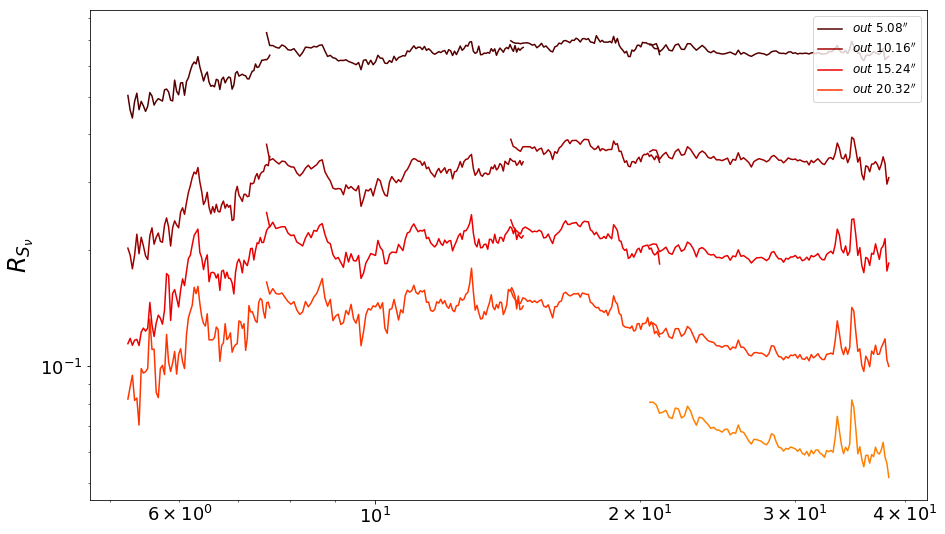

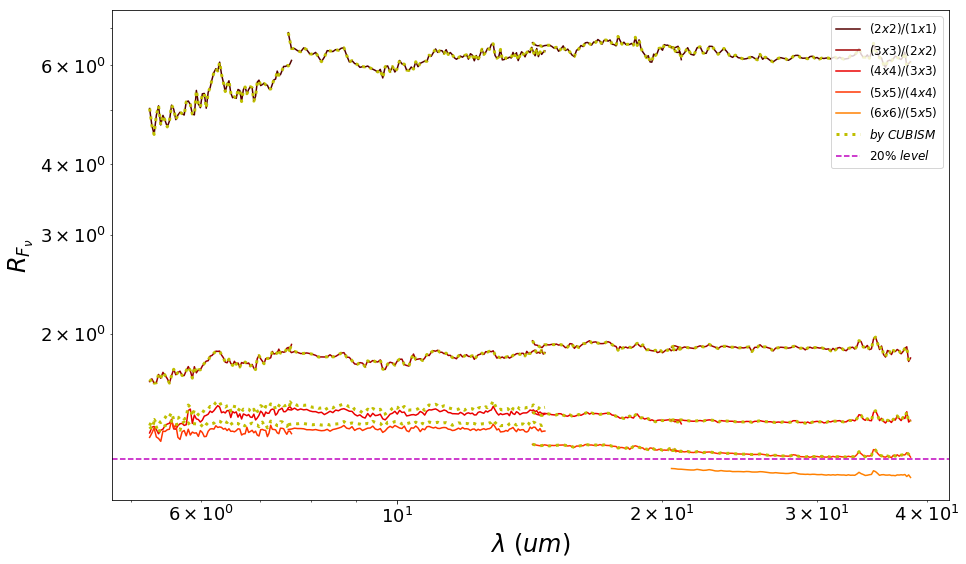

In [69]:
Plot_ratiooo(['ngc4826_Sy2'], 3, 10, 'LL2')

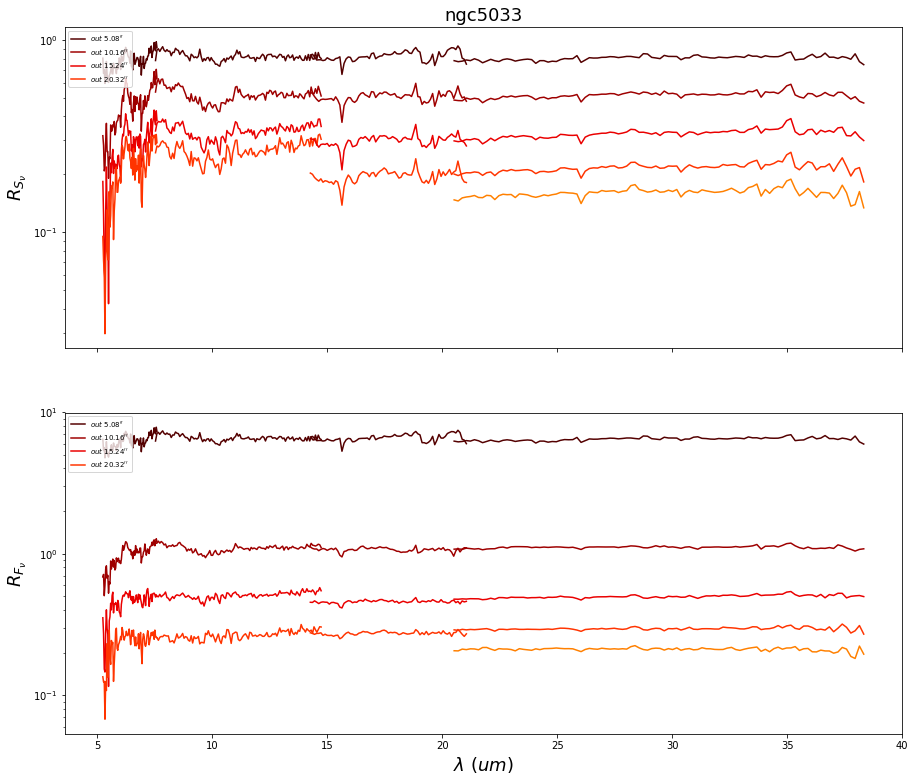

In [19]:
Plot_ratiooo(['ngc5033_Sy2'], 3, 10, 'LL2')

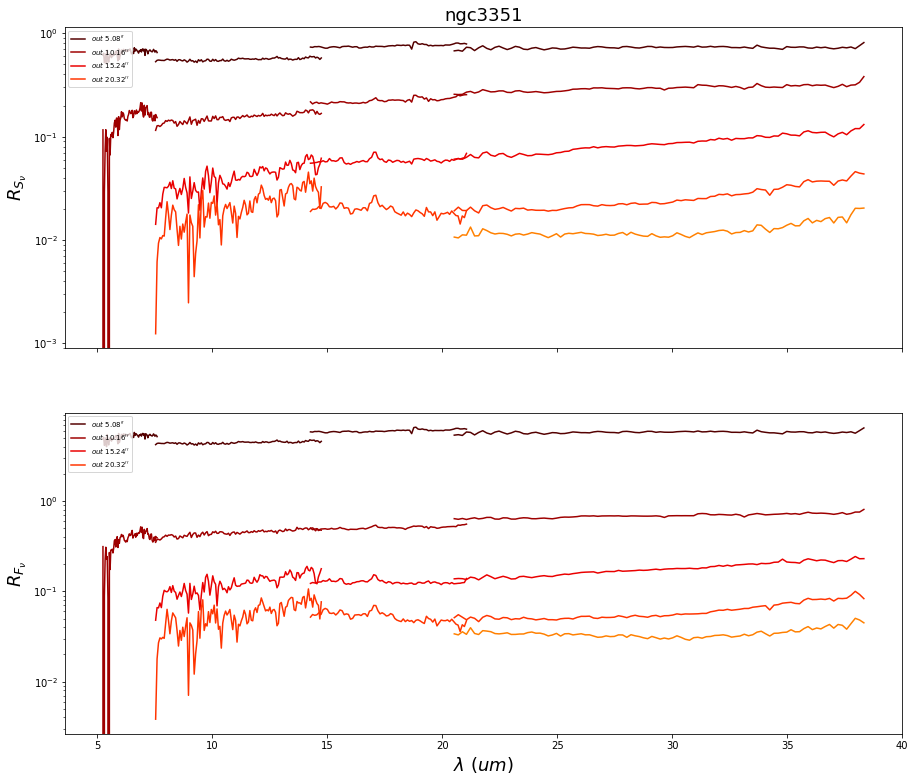

In [20]:
Plot_ratiooo(['ngc3351_SB'], 3, 10, 'LL2')

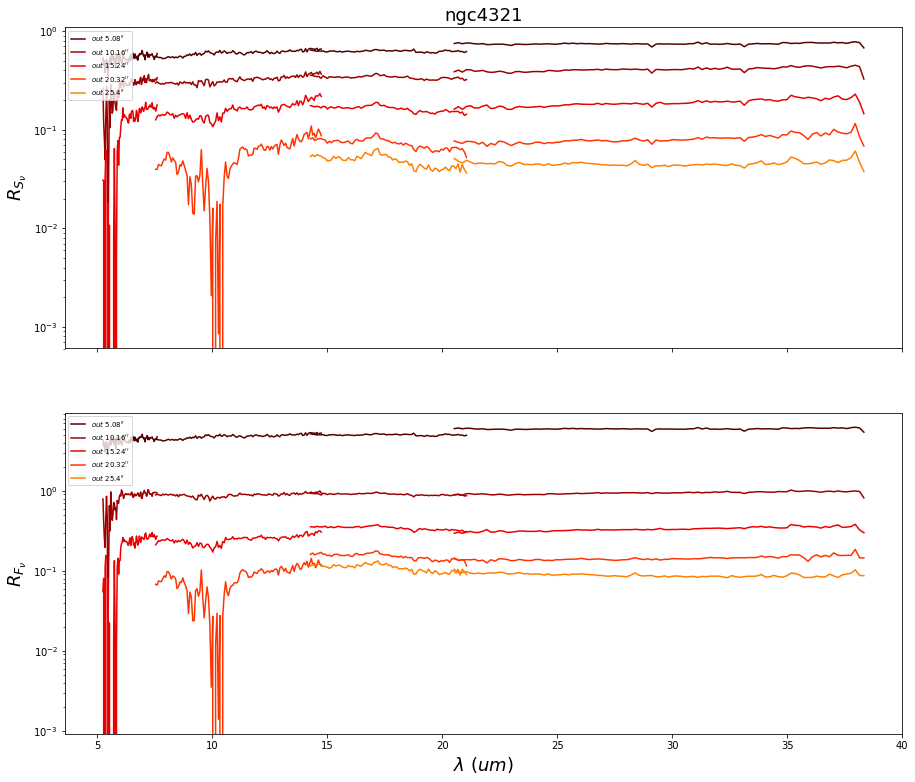

In [22]:
Plot_ratiooo(['ngc4321_L'], 3, 10, 'LL2')

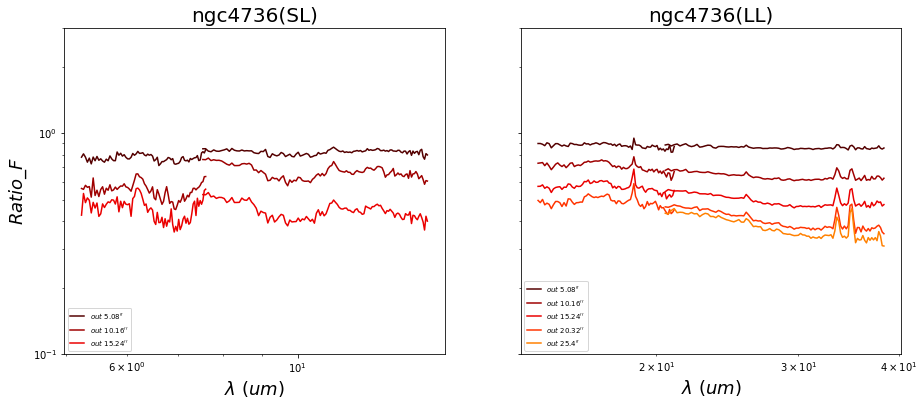

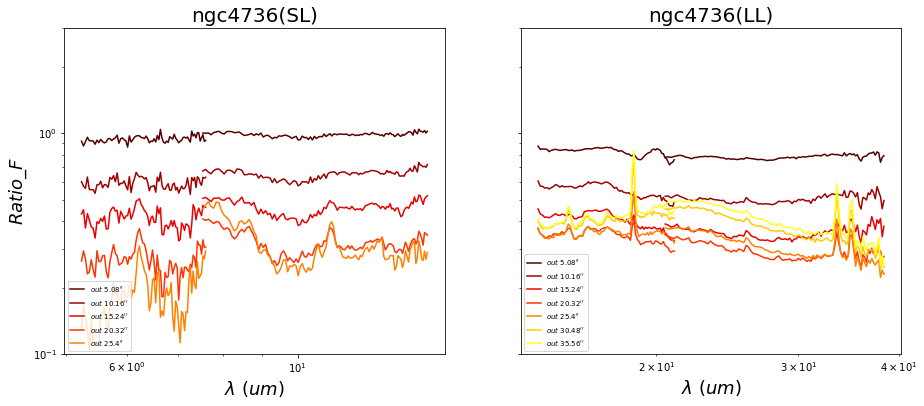

In [137]:
#Plot_ratio(['ngc4736_LINER'], 5, 10, 'LL2')

In [3]:
def Plot_spec(gal_name, sn, n_pix, O2):

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.io import fits
    from astropy.table import Table


    data_mode = ['SL2','SL1','LL2','LL1']
#gal_file = open('nuc_region_gal.txt','r')
#gal_name = gal_file.readlines()
#gal_name = ['ngc{0}'.format(str(3031))]

    for name in gal_name:
        f, ax = plt.subplots(1, 1, figsize=[15,9], sharey = True)
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
        for mode in data_mode:
            file_n = 'ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.split('_')[0],mode,O2)
            file_u = 'ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.split('_')[0],mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube[0].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]
#    nn = np.argmax(flux_sum)

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            flux_header = cube['PRIMARY'].header
#    print(n)
            flux_max = flux[xx[0]][yy[0]]
            flux_max_u = flux_u[xx[0]][yy[0]]

            Spec = Table([wave, flux_max, flux_max_u], names = ('Wavelength','Flux','Uncertainty'))
            Spec['Wavelength'].format = '.5f'
            Spec['Flux'].format = '.5f'
            Spec['Uncertainty'].format = '.6f'
            dirs = 'Spectra_{0}/{1}'.format(O2,name.split('_')[0])
            if(os.path.exists(dirs) != True):
                os.makedirs(dirs)
            Spec.write(dirs+'/{0}_{1}_CenPix.tbl'.format(name.split('_')[0], mode),format='ascii.ipac',overwrite=True)
            if(mode == O2):
                ax.errorbar(wave, flux_max, flux_max_u, ls='-', c='k', ecolor='k',elinewidth=1, label='$central\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_max, flux_max_u, ls='-', c='k', ecolor='k',elinewidth=1)

            bn = np.min([xx[0],yy[0],mm[0]-xx[0]-1,mm[1]-yy[0]-1])
            colors = plt.cm.hot(np.linspace(0,1,n_pix))
            for i in range(1,bn+1,1):
                flux_part = flux[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
                mask_part = ~np.isnan(flux_part.sum(axis=2))
                part_pix = mask_part.sum()
                flux_part = flux_part[mask_part].sum(axis=(0))
                flux_cen = flux[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                mask_cen = ~np.isnan(flux_cen.sum(axis=2))
                cen_pix = mask_cen.sum()
                flux_cen = flux_cen[mask_cen].sum(axis=(0))
                flux_out = (flux_part - flux_cen)/(part_pix - cen_pix)

                flux_part_u = flux_u[xx[0]-i:xx[0]+i+1,yy[0]-i:yy[0]+i+1]
#                    print((flux_part_u[mask_part]).shape)
                flux_part_u = (flux_part_u[mask_part]**2).sum(axis=(0))
                flux_cen_u = flux_u[xx[0]-i+1:xx[0]+i,yy[0]-i+1:yy[0]+i]
                flux_cen_u = (flux_cen_u[mask_cen]**2).sum(axis=(0))
                flux_out_u = np.sqrt(flux_part_u - flux_cen_u)/(part_pix - cen_pix)
                snr = (flux_out/flux_out_u).mean()
                if(snr>sn):
#                    Ratio = flux_out/flux_max
                    Spec = Table([wave, flux_out, flux_out_u], names = ('Wavelength','Flux','Uncertainty'))
                    Spec['Wavelength'].format = '.5f'
                    Spec['Flux'].format = '.5f'
                    Spec['Uncertainty'].format = '.6f'
                    Spec.write(dirs+'/{0}_{1}_out{2}Pix.tbl'.format(name.split('_')[0], mode, str(i)),format='ascii.ipac',overwrite=True)
                    par = (i)*np.abs(flux_header['CDELT1'])*3600
#                        ax1.plot(wave, flux_out, c=colors[i], ls='-', label='$out\ $'+str(round(par,2))+'$\'\'$')
                    if(mode == O2):
                        ax.errorbar(wave, flux_out, flux_out_u, ls='-', c=colors[i], ecolor=colors[i],elinewidth=1, label='$R_{square\ ring}\ $'+str(round(par,2))+'$\'\'$')
                        ax.legend(loc=2, fontsize='large')
                    else:
                        ax.errorbar(wave, flux_out, flux_out_u, ls='-', c=colors[i], ecolor=colors[i],elinewidth=1)

#            ax.set_title(name.split('_')[0],fontsize=24)
            plt.rc('xtick', labelsize=18)
            plt.rc('ytick', labelsize=18)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim(10**0,10**3)
            ax.set_xlabel('$\lambda\ (um)$', fontsize=24)
            ax.set_ylabel('$Flux\ density\ (MJy\ sr^{-1})$', fontsize=24)
            dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
            if(os.path.exists(dirs) == False):
                os.makedirs(dirs)
            f.savefig(dirs+'/{0}_rSpec.png'.format(name.split('_')[0]))
    return

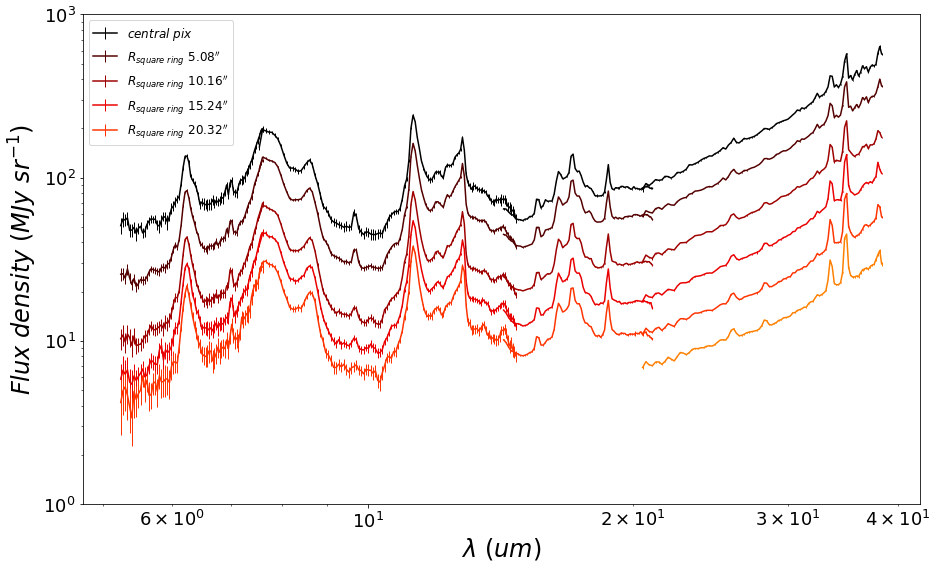

In [5]:
Plot_spec(['ngc4826_Sy2'], 3, 10, 'LL2')

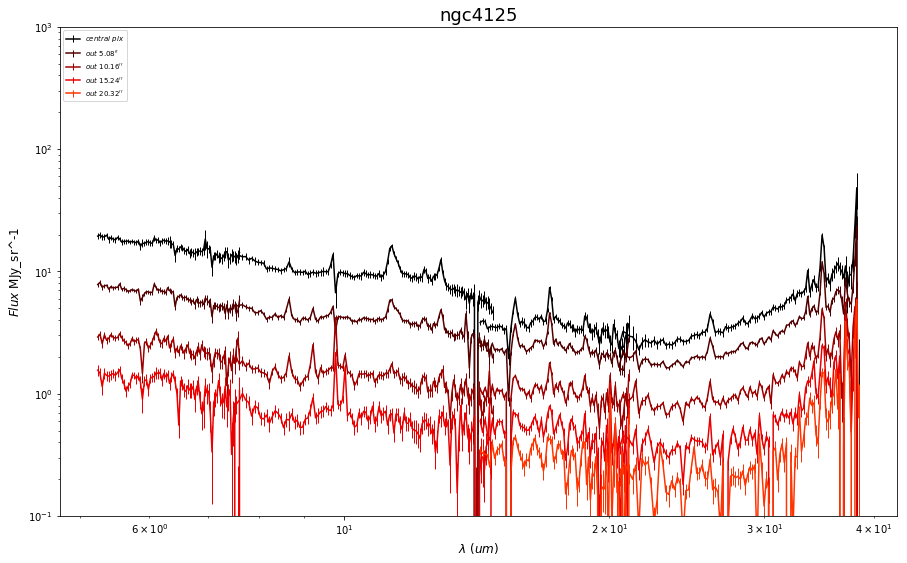

In [30]:
Plot_spec(['ngc4125_G'], 5, 10, 'LL2')

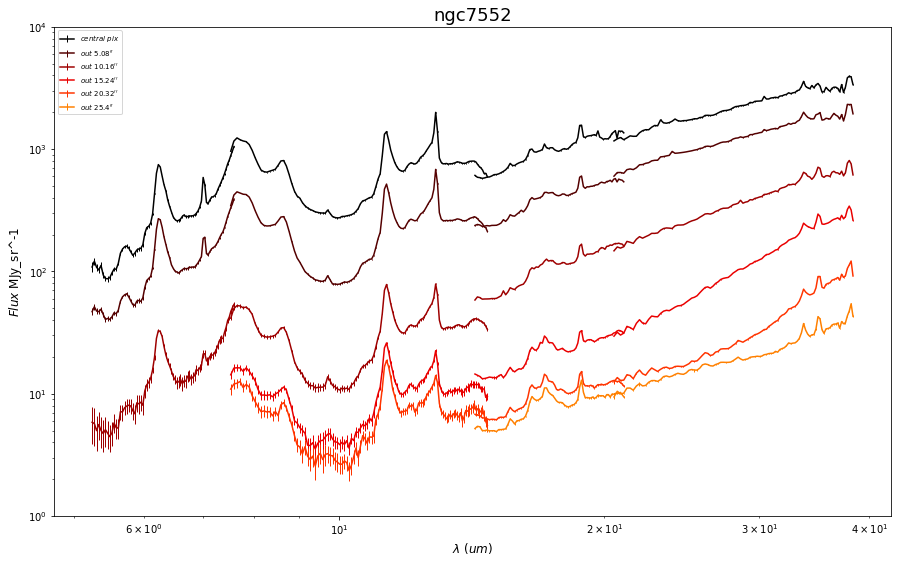

In [6]:
#Plot_spec(['ngc7552_SB'], 5, 10, 'LL2')

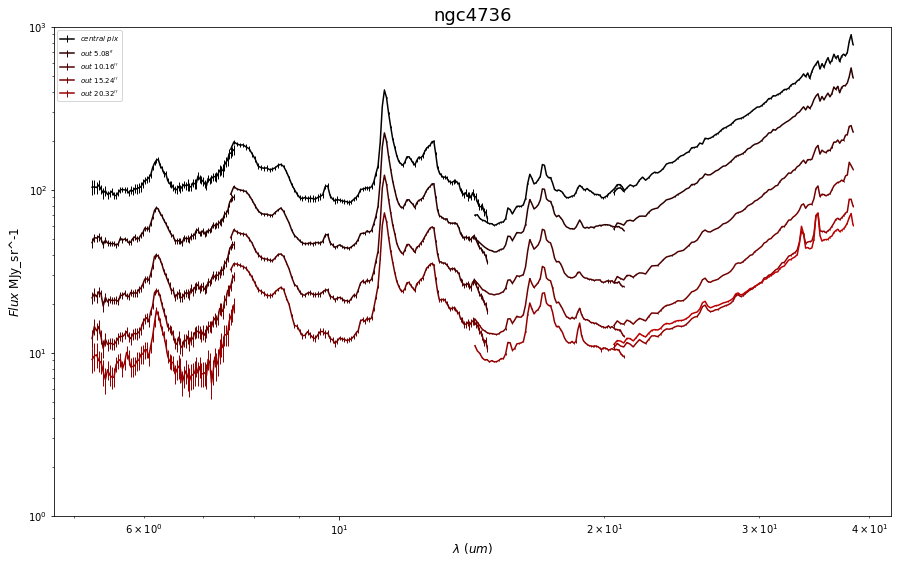

In [134]:
#Plot_spec(['ngc4736_LINER'], 5, 20, 'LL2')

In [8]:
def Plot_speccc(gal_name, sn, O2):

    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from astropy.io import fits


    data_mode = ['SL2','SL1','LL2','LL1']
#gal_file = open('nuc_region_gal.txt','r')
#gal_name = gal_file.readlines()
#gal_name = ['ngc{0}'.format(str(3031))]

    for name in gal_name:
        f, ax = plt.subplots(1, 1, figsize=[15,9], sharey = True)
        nnmm = 'ProjImg_{1}/{0}/'.format(name.split('_')[0],O2)
        coor = [[], []]
        for mode in data_mode:
            aabb = nnmm + '{0}_on2_{1}.fits'.format(mode, O2)
            if(os.path.isfile(aabb)):
                cube = fits.open(aabb)
            else:
                print('No such file:{0}'.format(aabb))
                continue
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_sum = flux.sum(axis=2)
            flux_sum[np.isnan(flux_sum)] = 0
            flux_header = cube[0].header
            crpixx, crpixy = np.where(flux_sum == np.max(flux_sum))
            coor_mode = wcss(flux_header, crpixx, crpixy)
            coor[0].append(coor_mode[0][0])
            coor[1].append(coor_mode[1][0])
        crval = [[0],[0]]
        pixmax = 0
        for num in range(0,len(coor[0])):
            ppmax = 0
            for mode in data_mode:
                aabb = nnmm +'{0}_on2_{1}.fits'.format(mode,O2)
                if(os.path.isfile(aabb)):
                    cube = fits.open(aabb)
                else:
                    print('No such file:{0}'.format(aabb))
                    continue
                flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
                flux_header = cube['PRIMARY'].header
                crpix = wcss3(flux_header, [coor[0][num]], coor[1][num])
                xx = [int(round(crpix[0][0],0))]
                yy = [int(round(crpix[1][0],0))]
                ppmax = ppmax + flux[xx[0], yy[0]].sum()
            if(ppmax > pixmax):
                pixmax = ppmax
                crval[0][0] = coor[0][num]
                crval[1][0] = coor[1][num]
        for mode in data_mode:
            file_n = 'ProjImg_{2}/{0}/{1}_on2_{2}.fits'.format(name.split('_')[0],mode,O2)
            file_u = 'ProjImg_{2}/{0}/{1}_on2_{2}_unc.fits'.format(name.split('_')[0],mode,O2)
            if(os.path.isfile(file_n)):
                cube = fits.open(file_n)
                cube_u = fits.open(file_u)
            else:
                print('No such file:{0}'.format(file_n))
                continue
#            cube.info()

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
            flux = np.transpose(cube['PRIMARY'].data, axes=(2, 1, 0))
            flux_u = np.transpose(cube_u['PRIMARY'].data, axes=(2, 1, 0))
            flux_header = cube[0].header
            crpix = wcss3(flux_header, crval[0], crval[1])
            mm = [flux_header['NAXIS1'], flux_header['NAXIS2']]
            xx = [int(round(crpix[0][0],0))]
            yy = [int(round(crpix[1][0],0))]
#    nn = np.argmax(flux_sum)

            wave = cube['WCS-TAB'].data[0][0]
            wave.resize(len(wave))

            flux_header = cube['PRIMARY'].header
#    print(n)
            flux_max = flux[xx[0]][yy[0]]
            flux_max_u = flux_u[xx[0]][yy[0]]
            if(mode == O2):
                ax.errorbar(wave, flux_max, flux_max_u, ls='-', c='k', ecolor='k',elinewidth=1, label='$central\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_max, flux_max_u, ls='-', c='k', ecolor='k',elinewidth=1)

            flux_left = flux[xx[0]-1][yy[0]]
            flux_left_u = flux_u[xx[0]-1][yy[0]]
            if(mode == O2):
                ax.errorbar(wave, flux_left, flux_left_u, ls='-', c='c', ecolor='c',elinewidth=1, label='$left\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_left, flux_left_u, ls='-', c='c', ecolor='c',elinewidth=1)

            flux_right = flux[xx[0]+1][yy[0]]
            flux_right_u = flux_u[xx[0]+1][yy[0]]
            if(mode == O2):
                ax.errorbar(wave, flux_right, flux_right_u, ls='-', c='b', ecolor='b',elinewidth=1, label='$right\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_right, flux_right_u, ls='-', c='b', ecolor='b',elinewidth=1)

            flux_above = flux[xx[0]][yy[0]+1]
            flux_above_u = flux_u[xx[0]][yy[0]+1]
            if(mode == O2):
                ax.errorbar(wave, flux_above, flux_above_u, ls='-', c='r', ecolor='r',elinewidth=1, label='$above\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_above, flux_above_u, ls='-', c='r', ecolor='r',elinewidth=1)

            flux_below = flux[xx[0]][yy[0]-1]
            flux_below_u = flux_u[xx[0]][yy[0]-1]
            if(mode == O2):
                ax.errorbar(wave, flux_below, flux_below_u, ls='-', c='m', ecolor='m',elinewidth=1, label='$below\ pix$')
                ax.legend(loc=2, fontsize='x-small')
            else:
                ax.errorbar(wave, flux_below, flux_below_u, ls='-', c='m', ecolor='m',elinewidth=1)

            ax.set_title(name.split('_')[0],fontsize=18)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim(10**0,10**3)
            ax.set_xlabel('$\lambda\ (um)$', fontsize=12)
            ax.set_ylabel('$Flux\ $'+flux_header['BUNIT'], fontsize=12)
            dirs = 'Image_{0}/{1}'.format(O2,name.split('_')[0])
            f.savefig(dirs+'/{0}_rSpec.png'.format(name.split('_')[0]))

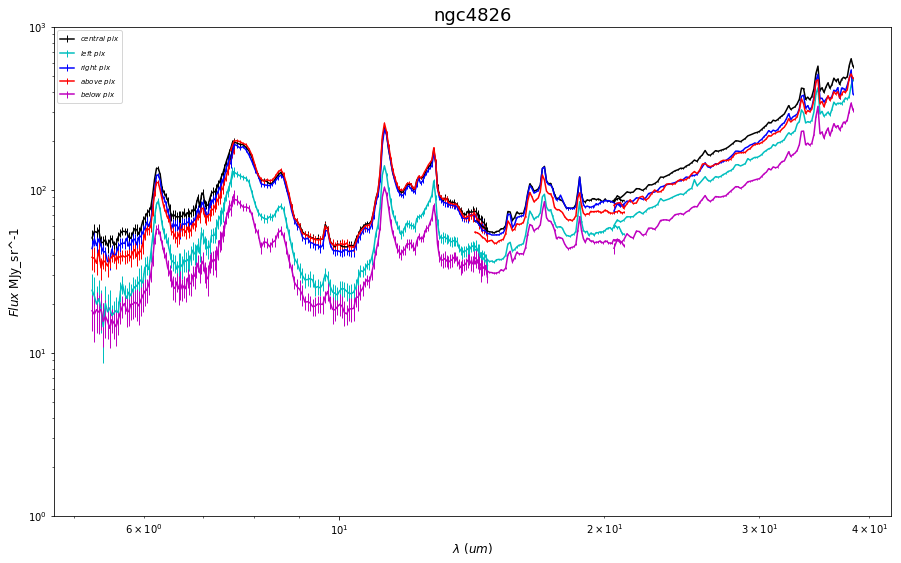

In [37]:
#Plot_speccc(['ngc4826_Sy2'], 5, 'LL2')

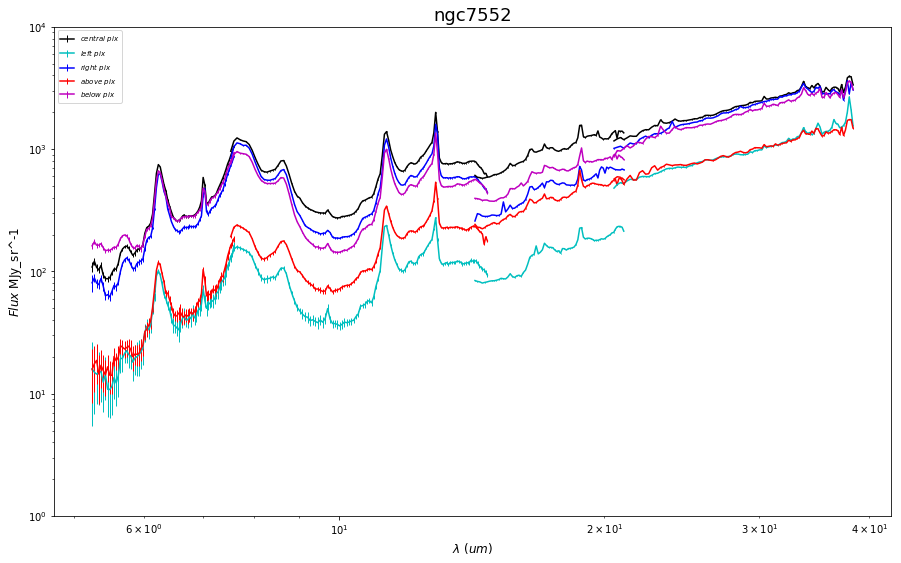

In [9]:
#Plot_speccc(['ngc7552_SB'], 5, 'LL2')

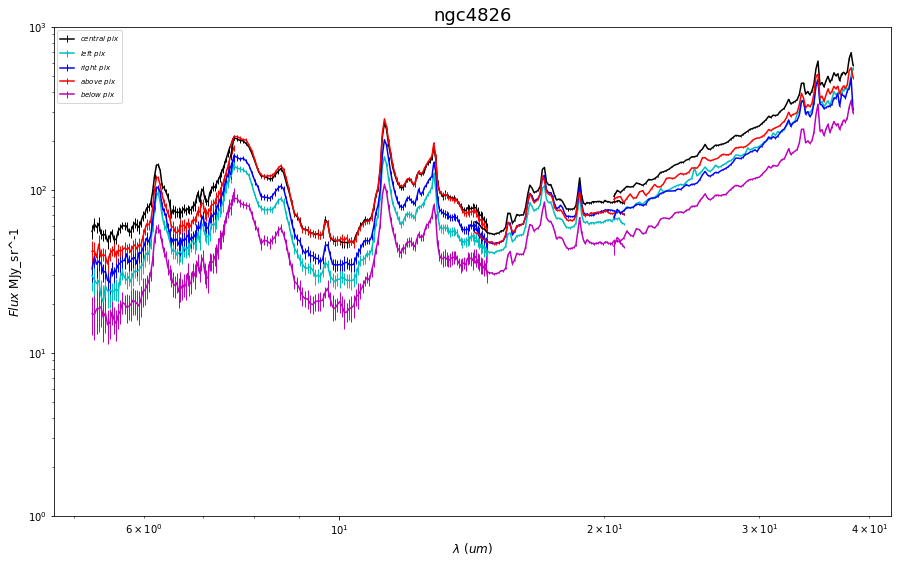

In [38]:
#Plot_speccc(['ngc4826_Sy2'], 5, 'LL1')

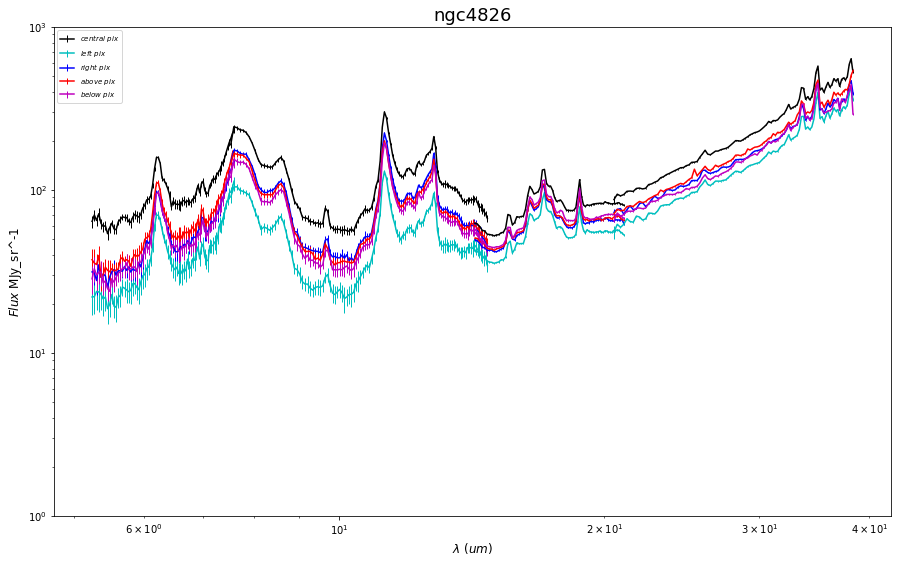

In [39]:
#Plot_speccc(['ngc4826_Sy2'], 5, 'SL2')

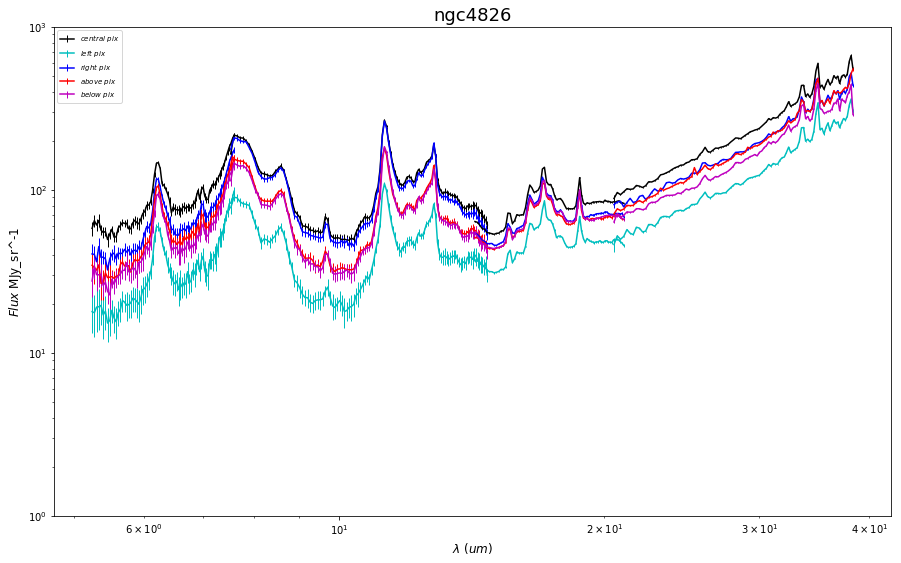

In [40]:
#Plot_speccc(['ngc4826_Sy2'], 5, 'SL1')

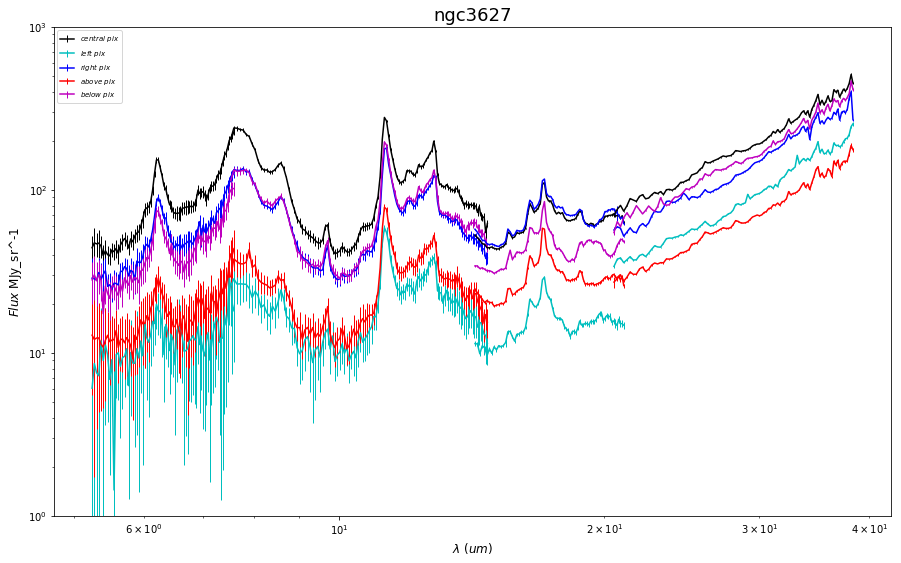

In [41]:
#Plot_speccc(['ngc3627_Sy2'], 5, 'LL2')

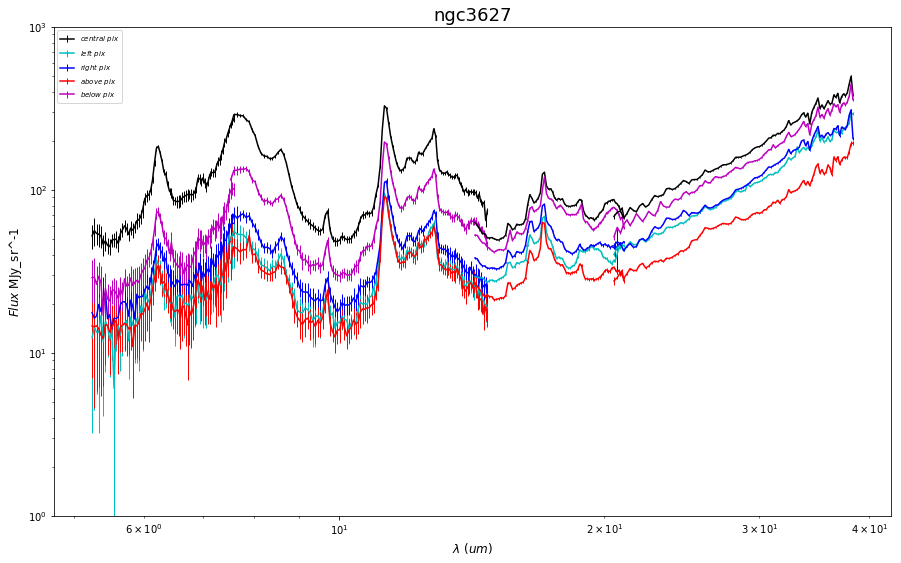

In [42]:
#Plot_speccc(['ngc3627_Sy2'], 5, 'LL1')

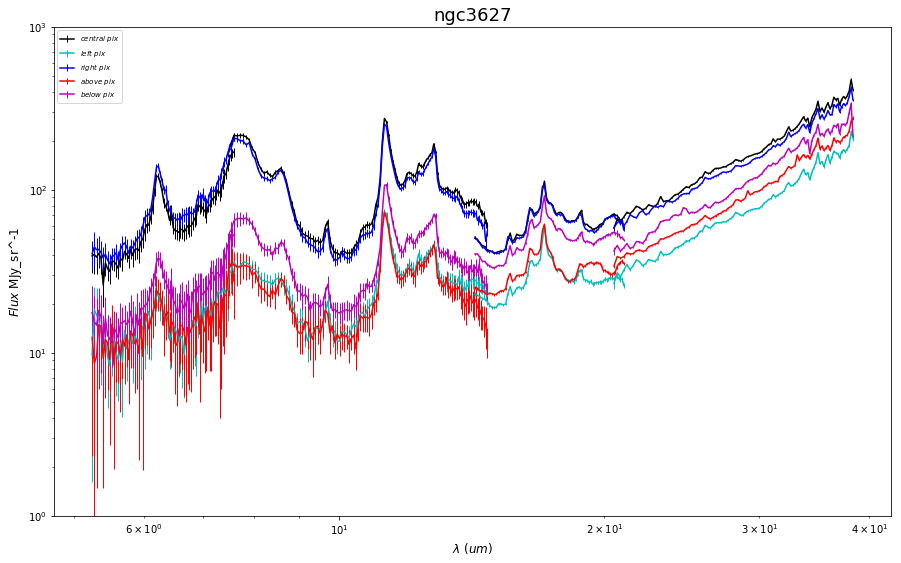

In [43]:
#Plot_speccc(['ngc3627_Sy2'], 5, 'SL2')

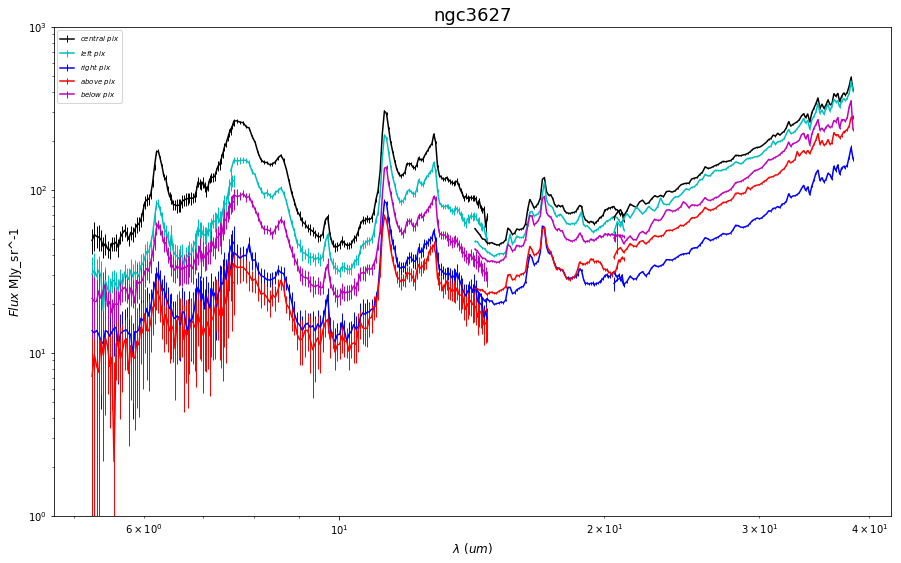

In [44]:
#Plot_speccc(['ngc3627_Sy2'], 5, 'SL1')